# MVP

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [1]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer

import lightgbm as lgb

from lightgbm import LGBMClassifier

In [3]:
from thesis_lib.utils import * 

#### First we load the data, which is already splitted on train, validation and test sets. We do not load test data, as we won't look at it until the end of the project.

In [4]:
#train_set, val_set = load_datasets('data/hospital_dataset')

In [6]:
class Data():
    def __init__(self,target='discharge'):
        self.target = target
        
    def load(self,path='data/hospital_dataset'):
        
        self.train = Dataset(path,'train',target_col=self.target)
        self.val = Dataset(path,'validation',target_col=self.target)
        self.test = Dataset(path,'test',target_col=self.target)
        
        return self
        
    def get_stats(self):
        total_data = 0
        summary = []

        for dataset_type in ['train','val','test']:
            dataset = getattr(self,dataset_type)
            data_len,n_cols = dataset.X.shape
            total_data +=  data_len

            negatives, positives = dataset.y.value_counts()
            negative_prop, positive_prop = dataset.y.value_counts(normalize=True)
            
            start_date = min(dataset.X.date)
            end_date = max(dataset.X.date)

            dataset_summary = {'dataset_type': dataset_type,
                               'n_observations': data_len,
                               'relative_size': None,
                               'n_cols': n_cols,
                               'positives': positives,
                               'negatives':negatives,
                               'positive_prop': positive_prop,
                               'negative_prop': negative_prop,
                               'min_date': start_date,
                               'max_date': end_date
                              }
            summary.append(dataset_summary)

        summary_df = pd.DataFrame(summary)
        summary_df['relative_size'] = summary_df['n_observations']/total_data
        
        return summary_df.set_index('dataset_type').T



class Dataset():
    def __init__ (self, path, dataset_type, target_col):
        
        self.dataset_type = dataset_type
        self.parquets_folder = path
        self.target_col = target_col

        self.X,self.y = self.load_dataset()
        self.X_transf = None
        
    def get_dataset(self, parquets_folder,dataset_type):    
    
        path= parquets_folder+'/'
        filenames = ['hospital_train_data.parquet','hospital_val_data.parquet','hospital_test_data.parquet']

        for file in filenames:
            if not os.path.isfile(path+file):
                print(file, 'not available in the specified folder')
            else:
                if '_train_' in file and dataset_type == 'train':
                    print('Loading dataset: ',file)
                    data = pd.read_parquet(path+file)
                elif '_val_' in file and dataset_type == 'validation':
                    print('Loading dataset: ',file)
                    data = pd.read_parquet(path+file)
                elif '_test_' in file and dataset_type == 'test':
                    print('Loading dataset: ',file)
                    data = pd.read_parquet(path+file)
        
        return data 
    
    def load_dataset(self):
        
        raw_data = self.get_dataset(self.parquets_folder, 
                                   self.dataset_type)
        
        y_data = raw_data[self.target_col]
        X_data = raw_data.drop(self.target_col,axis=1)
        
        return X_data, y_data


In [1]:
import sys

In [2]:
sys.version

'3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 12:04:33) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [7]:
data = Data().load('data/hospital_dataset')
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


#### Feature selection & feature engineering

##### We need to choose the features we're going to train out model with. As a rule of thumb, in this first experiment, we'll use all the numerical features plus only the categorical features with less than 10 categories (as they're easier to encode)

In [8]:
class FeaturePreProcessor():
    def __init__(self):
        self.cols_to_drop = ['admission_id', 'birth_date', 'patient_id', 'date']
        
    def fit(self,X,y=None):
        
        X['admission_weekday'] = pd.to_datetime(X['admission_date']).dt.weekday.astype('str')
        X['date_weekday'] = pd.to_datetime(X['date']).dt.weekday.astype('str')
    
        X = X.drop(self.cols_to_drop,axis=1)
                
    def transform(self,X):
        
        return X 

In [9]:
class FeaturePreProcessor():
    def __init__(self):
        self.cols_to_drop = ['admission_id', 'birth_date', 'patient_id', 'date']
        
    def fit(self,X,y=None):
        return self
        
        
    def transform(self,X):
        X['admission_weekday'] = pd.to_datetime(X['admission_date']).dt.weekday.astype('str')
        X['date_weekday'] = pd.to_datetime(X['date']).dt.weekday.astype('str')
    
        X = X.drop(self.cols_to_drop,axis=1)
        
        return X
    
    def get_categorical_features(self,X,max_values=20):
        categorical = []
        for col in X:
            if X[col].dtype == 'object':
                if X[col].nunique() <= max_values:
                    categorical.append(col)
        return categorical
    
    def get_numerical_features(self,X):
        numerical = []
        for col in X:
            if X[col].dtype in ['float', 'int'] and col != 'discharge':
                numerical.append(col)
        return numerical
                
        

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, keys,is_categorical=False):
        self.key = keys
        self.is_categorical = is_categorical

    def fit(self, X, y=None):
        return self

    def transform(self, X):     
        return X[self.key].astype(str) if self.is_categorical else X[self.key]
    
class CustomScaler(StandardScaler):
    
    def __init__ (self, with_mean=True,with_std=True):
        super().__init__(with_mean=with_mean, 
                         with_std=with_std)
    
    def fit(self,X,y=None):
        self.feature_names = list(X.columns)
        return super().fit(X)
    
    def transform(self,X):
        return super().transform(X)
        
    def get_feature_names(self):
        return self.feature_names

class CustomEncoder(OneHotEncoder):
    
    def __init__(self):
        super().__init__(handle_unknown='ignore')
        
    def fit(self,X,y=None):
        self.features_headers = list(X.columns)
        return super().fit(X)
        
    def get_feature_names(self):
        return super().get_feature_names(self.features_headers)

In [26]:
transformer_dict = {'categorical': CustomEncoder(),
                   'numerical': CustomScaler()}

In [27]:
class FeatureProcessor(Pipeline):
    def __init__(self, features_list, transformer_type):
        self.features_list = features_list
        
        self.selector  = ItemSelector(
            keys=features_list,is_categorical= (transformer_type == 'categorical'))
        
        self.transformer = transformer_dict[transformer_type]
        
        super().__init__([('selector',self.selector),
                          (transformer_type, self.transformer)])
        
    def get_feature_names(self):
        return self.transformer.get_feature_names()

In [67]:
class Model():
    def __init__(self):
        pass
        
    def build_pipeline(self):
        
        self.features = FeatureUnion([
            ('numerical', FeatureProcessor(['patient_age'],'numerical')),
            ('categorical', FeatureProcessor(['date_weekday','request_origin'],'categorical'))])
        
        self.pipeline = Pipeline(steps=[
            ('preprocessing', FeaturePreProcessor() ),
            ('feature_extractor', self.features)])
        
        print(self.pipeline)
    
    @property
    def model_features(self):
        
        feature_names = []
        transformers = self.pipeline.named_steps['feature_extractor'].transformer_list
        for transformer in transformers:
            transformer_features = transformer[1].get_feature_names()
            feature_names.extend(transformer_features)
          
        #HACK
        feature_names = ["".join (c if c.isascii() else "_" for c in str(x)) for x in feature_names]
        
        return feature_names
    
    def train(self,data):
       
        print('fitting pipeline')
        self.pipeline.fit(data.train.X)
        
        print('transforming data')
        X_train = self.pipeline.transform(data.train.X)
        X_val = self.pipeline.transform(data.val.X)
        
        lgb_train = lgb.Dataset(X_train,
                                label=data.train.y,
                                feature_name=self.model_features
                               )
        lgb_eval = lgb.Dataset(X_val,
                               label=data.val.y,
                               feature_name=self.model_features,
                               reference=lgb_train)
        
        print('training classifier')
        num_round = 100
        param = {'num_leaves': 31, 
                 'objective': 'binary', 
                 'metric': 'auc',
                 'is_unbalance': True}
                                
        self.classifier = lgb.train(param, lgb_train, num_round, valid_sets=[lgb_eval])
        
        
        
    def predict(self,dataset):
        
        if not dataset.X_transf:
            dataset.X_transf = self.pipeline.transform(dataset.X)
         
        y_pred = self.classifier.predict(dataset.X_transf)
        
        return y_pred
    
    def validate(self,dataset):
        
        y_true = dataset.y
        y_pred = self.predict(dataset)
        
        return roc_auc_score(y_true,y_pred)
    
    def plot_feature_importance(self, importance_type='split',n_features=30):
        lgb.plot_importance(self.classifier, 
                            figsize=(10,10),
                            max_num_features= n_features,
                           importance_type=importance_type)
        
        

In [68]:
baseline = Model()

In [69]:
baseline.build_pipeline()

Pipeline(memory=None,
     steps=[('preprocessing', <__main__.FeaturePreProcessor object at 0x1a2f21e518>), ('feature_extractor', FeatureUnion(n_jobs=None,
       transformer_list=[('numerical', FeatureProcessor(features_list=['patient_age'], transformer_type=None)), ('categorical', FeatureProcessor(features_list=['date_weekday', 'request_origin'],
         transformer_type=None))],
       transformer_weights=None))])


In [70]:
%%capture
baseline.train(data)

AttributeError: 'str' object has no attribute 'isascii'

In [58]:
baseline.validate(data.val)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [219]:
categorical = []
numerical = []
for col in train_set:
    if train_set[col].dtype == 'object':
        if train_set[col].nunique() < 10:
            categorical.append(col)
    elif train_set[col].dtype in ['float', 'int'] and col != 'discharge':
        numerical.append(col)

In [199]:
categorical

['gender',
 'entity_group',
 'origin',
 'isolation',
 'ARM_TEP',
 'CEC_TEP',
 'request_sector',
 'admission_weekday',
 'date_weekday']

In [200]:
numerical

['hosp_day_number',
 'images_count',
 'images_cumulative',
 'images_emergencies',
 'images_requester_roles_count',
 'images_requesters_count',
 'images_study_types_count',
 'labos_count',
 'labos_cumulative',
 'labos_emergencies',
 'labos_requester_roles_count',
 'labos_requesters_count',
 'labos_set_count',
 'labos_set_cumulative',
 'sectors_count',
 'sectors_last_stay',
 'surgeries_count',
 'surgeries_cumulative',
 'surgeries_post_surgery_duration',
 'surgeries_pre_surgery_duration',
 'surgeries_prep_duration',
 'surgeries_services_count',
 'surgeries_surgery_delay',
 'surgeries_surgery_duration',
 'surgeries_types_count',
 'emergency_service',
 'new_born_weight',
 'new_born_gestation_age',
 'PIM2TEP',
 'high_risk_TEP',
 'low_risk_TEP',
 'patient_age']

####  We'll model the problem as a classification problem where our target is the variable indicating wether the patient was discharged on that day (=1) or not (=0).

In [220]:
y_train = train_set['discharge']
y_val = val_set['discharge']

In [221]:
X_train = train_set.drop('discharge',axis=1)
X_val = val_set.drop('discharge',axis=1)

In [222]:
for col in categorical:
    
    X_train[col] = X_train[col].astype('category')
    X_train[col] = pd.Categorical(X_train[col].cat.codes+1)
    
    X_val[col] = X_val[col].astype('category')
    X_val[col] = pd.Categorical(X_val[col].cat.codes+1)

In [224]:
X_val.shape

(33482, 73)

In [225]:
X_train.shape

(319150, 73)

#### As a first approach we'll use lightgbm which uses decision trees on a boosting ensemble schema. The selection of the algorythmn responds primaryly to efficiences in the handling of the data that makes training extremly fast. Later on other algorythns will be tested.

In [212]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train[['patient_age','date_weekday']], 
                         label=y_train, 
                         feature_name=['patient_age','date_weekday'], 
                         categorical_feature=['date_weekday'],
                        free_raw_data=False)

validation_data = lgb.Dataset(X_val[['patient_age','date_weekday']], 
                              label=y_val, 
                              reference=train_data,
                             feature_name=['patient_age','date_weekday'], 
                             categorical_feature=['date_weekday'],
                              free_raw_data=False)

In [42]:
train_data.save_binary('data/hospital_dataset/train.bin')
validation_data.save_binary('data/hospital_dataset/validation.bin')

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].cat.set_categories(category)


In [230]:
train_data = lgb.Dataset(X_train[['patient_age','date_weekday']], 
                         label=y_train, 
                         feature_name=['patient_age','date_weekday'], 
                         categorical_feature=['date_weekday'],
                        free_raw_data=False)

In [231]:
validation_data = lgb.Dataset(X_val[['patient_age','date_weekday']], 
                              label=y_val, 
                              reference=train_data,
                             feature_name=['patient_age','date_weekday'], 
                             categorical_feature=['date_weekday'],
                              free_raw_data=False)

#### Model configuration.
At this instance, we'll use static models params. Later on model selection techniques will be used in order to find the optimal combination of parameters.
Its importance to notice that we are working with unbalanced data, we'll make this explicitly to the lgbm so that it takes into account during learning. 
As a performance metric, for now we'll use AUC-roc. This is a classification metric that has several advantages over accuracy when dealing with unbalanced classes. We may decide later on to build our own performance metric for this problem. But at this point we'll be satisfied with AUC-roc

In [206]:
y_train.value_counts()

0.0    276453
1.0     42697
Name: discharge, dtype: int64

#### Model training

We'll train the model by building 100 decision trees and then combining their results. The advantage of this type of methods, called ensemble methods, is that they prevent overfitting by combining the results results of many models built with different features thus suppresing the noise that each model migth have learned.

In [232]:
num_round = 100
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.653271
[2]	valid_0's auc: 0.654043
[3]	valid_0's auc: 0.654585
[4]	valid_0's auc: 0.65499
[5]	valid_0's auc: 0.655281
[6]	valid_0's auc: 0.655181
[7]	valid_0's auc: 0.655219
[8]	valid_0's auc: 0.655003
[9]	valid_0's auc: 0.655056
[10]	valid_0's auc: 0.654999
[11]	valid_0's auc: 0.655008
[12]	valid_0's auc: 0.654918
[13]	valid_0's auc: 0.654765
[14]	valid_0's auc: 0.654893
[15]	valid_0's auc: 0.654869
[16]	valid_0's auc: 0.654894
[17]	valid_0's auc: 0.654985
[18]	valid_0's auc: 0.654917
[19]	valid_0's auc: 0.65491
[20]	valid_0's auc: 0.654971
[21]	valid_0's auc: 0.655052
[22]	valid_0's auc: 0.655074
[23]	valid_0's auc: 0.655095
[24]	valid_0's auc: 0.655064
[25]	valid_0's auc: 0.655001
[26]	valid_0's auc: 0.655007
[27]	valid_0's auc: 0.654963
[28]	valid_0's auc: 0.654932
[29]	valid_0's auc: 0.654836
[30]	valid_0's auc: 0.654793
[31]	valid_0's auc: 0.65482
[32]	valid_0's auc: 0.654754
[33]	valid_0's auc: 0.654712
[34]	valid_0's auc: 0.654661
[35]	valid_0's auc: 0.6546

#### Performance

In [47]:
from sklearn.metrics import roc_auc_score

We measure the performance in both training and validation sets. Validation performance is of 0.86 (over a maximum of 1). Validation performance is not far from training performance (0.87), telling us that so far the model is not overfitting.

In [48]:
 roc_auc_score(y_val,bst.predict(X_val[categorical+numerical]))

0.8611652398632282

In [49]:
roc_auc_score(y_train,bst.predict(X_train[categorical+numerical]))

0.8725421787149726

#### Feature importance

Lightgbm let us know which of the features where the more important ones for the model. We'll take a look at them and try to make sense of it, considering the finding we made during the exploration stage.

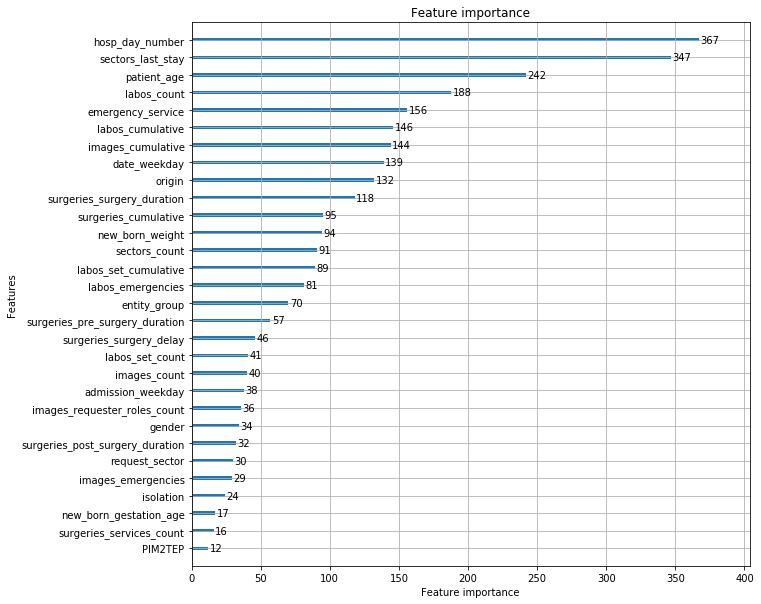

In [50]:
lgb.plot_importance(bst, figsize=(10,10),max_num_features=30, importance_type='split')

By looking at this chart we confirm some of our hints about variables that we expected to perform very well (as age and origin). 
We also see that the model has find some obvious relationships and its taking advantage of them (for example, how many days the patient's has already been hospitalized seems crucial to predict whether it will continue or not).
Finally the learning has unconvered some important patterns that weren't so clear for us. For example the variable 'sector_last_stay'  which refers to the sector where the patient is currently hospitalized ends up being the most important one. 

It is necessary to clarify that this chart does not say anything about the direction of the relationship with the target variable. Moreover, as we are working with decision trees, relationships might very well not be linear, meaning that sometimes is the combination of certain feature values that lets the model predict in a certain way.
Later on, further analysis will be done in the model output in order to understand the impact certain variables have on the model predictions as we do not want the model to be a black box, specially considering the sensitivity of the problem at stake.